In [1]:
import pandas as pd

url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/features.txt'
feature_name_df = pd.read_csv(url, sep='\s+', header=None, names=['column_index', 'column_name'])
feature_name = feature_name_df.iloc[:, 1].values.tolist()

In [2]:
X_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/X_train.txt'
X_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/X_test.txt'

X_train = pd.read_csv(X_train_url, sep='\s+', header=None)
X_test = pd.read_csv(X_test_url, sep='\s+', header=None)

In [3]:
X_train.columns = feature_name
X_test.columns = feature_name

In [4]:
y_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/y_train.txt'
y_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/y_test.txt'

y_train = pd.read_csv(y_train_url, sep='\s+', header=None, names=['action'])
y_test = pd.read_csv(y_test_url, sep='\s+', header=None, names=['action'])

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

In [17]:
from sklearn.decomposition import PCA

def get_pca_data(ss_data, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(ss_data)
    
    return pca.transform(ss_data), pca

In [18]:
HAR_pca, pca = get_pca_data(X_train, n_components=2)
HAR_pca.shape

(7352, 2)

In [19]:
pca.mean_.shape, pca.components_.shape

((561,), (2, 561))

In [20]:
cols = ['pca_'+str(n) for n in range(pca.components_.shape[0])]
cols

['pca_0', 'pca_1']

In [21]:
def get_pd_from_pca(pca_data, col_num):
    cols = ['pca_'+str(n) for n in range(col_num)]
    
    return pd.DataFrame(pca_data, columns=cols)

In [22]:
HAR_pca, pca = get_pca_data(X_train, n_components=2)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train
HAR_pd_pca.head()

,pca_0,pca_1,action
0,-5.520280,-0.290278,5
1,-5.535350,-0.082530,5
2,-5.474988,0.287387,5
3,-5.677232,0.897031,5
4,-5.748749,1.162952,5


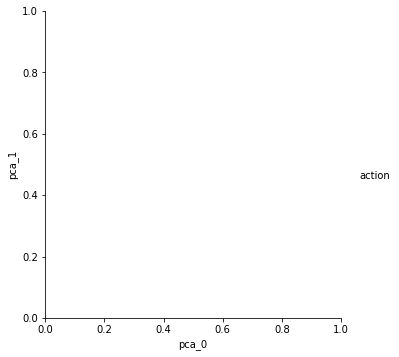

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.pairplot(HAR_pd_pca, hue='action', height=5, x_vars=['pca_0'], y_vars=['pca_1'])
plt.show()

In [26]:
import numpy as np

def print_variance_ratio(pca):
    print('variance ratio: ', pca.explained_variance_ratio_)
    print('sum of variance ratio: ', np.sum(pca.explained_variance_ratio_))
print_variance_ratio(pca)

variance ratio:  [0.6255444  0.04913023]
sum of variance ratio:  0.6746746270487801


In [28]:
HAR_pca, pca = get_pca_data(X_train, n_components=3)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train
print_variance_ratio(pca)

variance ratio:  [0.6255444  0.04913023 0.04121467]
sum of variance ratio:  0.7158893015785958


In [29]:
HAR_pca, pca = get_pca_data(X_train, n_components=10)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train
print_variance_ratio(pca)

variance ratio:  [0.6255444  0.04913023 0.04121467 0.01874956 0.0169486  0.01272069
 0.01176685 0.01068973 0.00969378 0.00858012]
sum of variance ratio:  0.8050386404542851


In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {
    'max_depth' : [6, 8, 10],
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [8, 12],
    'min_samples_split': [8, 12]
}

rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv=2, n_jobs=-1)
grid_cv.fit(HAR_pca, y_train.values.reshape(-1,))

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=13),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10], 'min_samples_leaf': [8, 12],
                         'min_samples_split': [8, 12],
                         'n_estimators': [50, 100, 200]})

In [33]:
cv_result_df = pd.DataFrame(grid_cv.cv_results_)
target_col = ['rank_test_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth']
cv_result_df[target_col].sort_values('rank_test_score').head()

,rank_test_score,mean_test_score,param_n_estimators,param_max_depth
17,1,0.838275,200,8
14,1,0.838275,200,8
32,3,0.837595,200,10
35,3,0.837595,200,10
26,5,0.837187,200,10


In [34]:
grid_cv.best_params_

{'max_depth': 8,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 200}

In [35]:
grid_cv.best_score_

0.8382752992383025

In [40]:
from sklearn.metrics import accuracy_score

rf_clf_best = grid_cv.best_estimator_
rf_clf_best.fit(HAR_pca, y_train.values.reshape(-1,))

pred1 = rf_clf_best.predict(pca.transform(X_test))
accuracy_score(y_test, pred1)

0.8534102477095351

In [41]:
import time
from xgboost import XGBClassifier

evals = [(pca.transform(X_test), y_test)]

start_time = time.time()
xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb.fit(HAR_pca, y_train.values.reshape(-1,), early_stopping_rounds=10, eval_set=evals)
print('Fit time : ', time.time() - start_time)

[0]	validation_0-merror:0.22531
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.22192
[2]	validation_0-merror:0.20461
[3]	validation_0-merror:0.20394
[4]	validation_0-merror:0.20122
[5]	validation_0-merror:0.20292
[6]	validation_0-merror:0.19749
[7]	validation_0-merror:0.19715


c:\users\luvu1\anaconda3\envs\dss15\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[8]	validation_0-merror:0.19376
[9]	validation_0-merror:0.19308
[10]	validation_0-merror:0.18968
[11]	validation_0-merror:0.18731
[12]	validation_0-merror:0.18426
[13]	validation_0-merror:0.18426
[14]	validation_0-merror:0.18154
[15]	validation_0-merror:0.18188
[16]	validation_0-merror:0.18052
[17]	validation_0-merror:0.17815
[18]	validation_0-merror:0.17781
[19]	validation_0-merror:0.17441
[20]	validation_0-merror:0.17543
[21]	validation_0-merror:0.17509
[22]	validation_0-merror:0.17509
[23]	validation_0-merror:0.17441
[24]	validation_0-merror:0.17272
[25]	validation_0-merror:0.17068
[26]	validation_0-merror:0.17204
[27]	validation_0-merror:0.17102
[28]	validation_0-merror:0.17068
[29]	validation_0-merror:0.17068
[30]	validation_0-merror:0.17000
[31]	validation_0-merror:0.16695
[32]	validation_0-merror:0.16593
[33]	validation_0-merror:0.16559
[34]	validation_0-merror:0.16559
[35]	validation_0-merror:0.16356
[36]	validation_0-merror:0.16423
[37]	validation_0-merror:0.16457
[38]	validat

In [42]:
accuracy_score(y_test, xgb.predict(pca.transform(X_test)))

0.8618934509670851